In [161]:
from os.path import join
import pandas as pd
import seaborn as sns
import warnings

from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeRegressor


from deep_aqi import ROOT


pd.set_option('expand_frame_repr', False)
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 25)
pd.options.mode.chained_assignment = None 

In [165]:
warnings.filterwarnings("ignore")

In [95]:
def show_result(results):
    print(results.describe())
    results = results.reset_index()
    results = results.melt(id_vars='index', value_vars=['MAE', 'MSE', 'MdAE', 'R2'])
    results = results.loc[results.variable != 'MSE', :]
    
    sns.boxplot(x=results['variable'], y=results['value'])

In [87]:
PROCESSED_DATA = join(ROOT, 'data', 'processed')
INTERIM_DATA = join(ROOT, 'data', 'interim')
RAW_DATA = join(ROOT, 'data', 'raw')

In [3]:
file_path = join(PROCESSED_DATA, '88101.parquet')

data_source = pd.read_parquet(file_path)
target_column = data_source.columns[-1]

In [4]:
data_source.head()

,SiteCode,LocalDate,WindDir,WindSpeed,Temperature,Pressure,RelHum,PM2.5 - Local Conditions
index,,,,,,,,
0,California_Fresno_5001.0,2014-01-01 00:00:00,63.0,1.749611,5.555556,100660.0,67.0,80.0
1,California_Fresno_5001.0,2014-01-01 05:00:00,71.0,3.304821,3.888889,100660.0,69.0,43.0
2,California_Fresno_5001.0,2014-01-01 15:00:00,280.0,5.054432,17.777778,100520.0,29.0,62.0
3,California_Fresno_5001.0,2014-01-01 19:00:00,50.0,1.749611,11.666667,100660.0,53.0,83.0
4,California_Fresno_5001.0,2014-01-01 21:00:00,67.0,3.304821,8.888889,100660.0,58.0,75.0


In [140]:
def simple_linear_1(data_source):
    to_concat = []
    for site_code, df in data_source.groupby(by='SiteCode'):

        X = df.loc[:, ['WindDir', 'WindSpeed', 'Temperature', 'Pressure', 'RelHum']]
        Y = df.loc[:, target_column]

        X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=23)

        model = LinearRegression()

        model.fit(X_train, y_train)


        y_pred = model.predict(X_test)


        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mdae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mean = np.mean(df[df.columns[-1]])

        result = pd.DataFrame(index = [site_code],
                              data={'MAE': mae,
                                    'MSE': mse,
                                    'MdAE': mdae,
                                    'R2': r2,
                                    'MEAN': mean,
                                   })
        to_concat.append(result)

    return pd.concat(to_concat)


In [141]:
def simple_linear_2(data_source):
    to_concat = []
    for site_code, df in data_source.groupby(by='SiteCode'):

        df['Hour'] = df.LocalDate.dt.hour
        df = pd.concat([df, pd.get_dummies(df.Hour, prefix='Hour')], axis=1)
        df.drop('Hour', axis='columns', inplace=True)

        df['Weekday'] = df.LocalDate.dt.weekday
        df = pd.concat([df, pd.get_dummies(df.Weekday, prefix='Weekday')], axis=1)
        df.drop('Weekday', axis=1, inplace=True)

        df['Month'] = df.LocalDate.dt.month
        df = pd.concat([df, pd.get_dummies(df.Month, prefix='Month')], axis=1)
        df.drop('Month', axis=1, inplace=True)


        Y = df.loc[:, target_column]
        df.drop(['SiteCode', 'LocalDate', target_column], axis=1, inplace=True)

        X = df.copy()

        X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=23)

        model = LinearRegression()
        model.fit(X_train, y_train)


        y_pred = model.predict(X_test)


        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mdae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mean = np.mean(df[df.columns[-1]])

        result = pd.DataFrame(index = [site_code],
                              data={'MAE': mae,
                                    'MSE': mse,
                                    'MdAE': mdae,
                                    'R2': r2,
                                    'MEAN': mean,
                                   })
        to_concat.append(result)

    return pd.concat(to_concat)


In [171]:
to_concat = []
for site_code, df in data_source.groupby(by='SiteCode'):

    df['Hour'] = df.LocalDate.dt.hour
    df = pd.concat([df, pd.get_dummies(df.Hour, prefix='Hour')], axis=1)
    df.drop('Hour', axis='columns', inplace=True)

    df['Weekday'] = df.LocalDate.dt.weekday
    df = pd.concat([df, pd.get_dummies(df.Weekday, prefix='Weekday')], axis=1)
    df.drop('Weekday', axis=1, inplace=True)

    df['Month'] = df.LocalDate.dt.month
    df = pd.concat([df, pd.get_dummies(df.Month, prefix='Month')], axis=1)
    df.drop('Month', axis=1, inplace=True)


    Y = df.loc[:, target_column]
    df.drop(['SiteCode', 'LocalDate', target_column], axis=1, inplace=True)

    X = df.copy()

    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=23)

    
    pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge())])
    param_grid = {'scaler': [StandardScaler(), MinMaxScaler(), None],
                  'regressor': [Ridge(), DecisionTreeRegressor()],
                  }
    search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=)
    search.fit(X_train, y_train)
    search.score(X_test, y_test)



    y_pred = search.predict(X_test)


    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mdae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mean = np.mean(y_test)

    result = pd.DataFrame(index = [site_code],
                          data={'MAE': mae,
                                'MSE': mse,
                                'MdAE': mdae,
                                'R2': r2,
                                'MEAN': mean,
                               })
    to_concat.append(result)

In [172]:
results = pd.concat(to_concat)

             MAE         MSE       MdAE         R2       MEAN
count  49.000000   49.000000  49.000000  49.000000  49.000000
mean    4.022020   44.638519   3.101958   0.150941   8.150411
std     1.017409   55.876691   0.739643   0.077769   2.410633
min     1.874379    6.083770   1.388242   0.010011   2.551030
25%     3.535663   25.581870   2.686313   0.099986   6.696176
50%     3.999909   35.591256   3.127678   0.143231   8.298920
75%     4.467746   45.351145   3.518470   0.182759   9.516597
max     7.910682  397.488747   5.349622   0.370469  16.229892


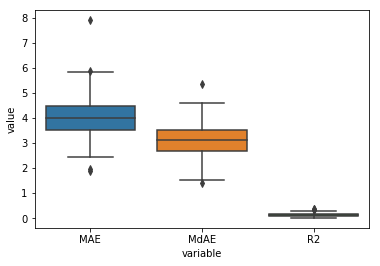

In [173]:
show_result(results)

In [185]:
results.sort_values(by='R2', ascending=False).head(10)

,MAE,MSE,MdAE,R2,MEAN
California_Fresno_5001.0,7.910682,142.191132,5.349622,0.370469,16.229892
Vermont_Rutland_2.0,4.590091,41.442419,3.569873,0.356563,7.717438
California_Madera_2010.0,5.881897,71.715118,4.280538,0.307067,12.352582
Vermont_Chittenden_7.0,1.874379,6.083770,1.513516,0.275147,3.039490
Pennsylvania_Allegheny_8.0,4.098183,29.411019,3.289255,0.255180,9.519981
Colorado_Rio Blanco_6.0,2.444939,13.594408,1.766252,0.250606,7.821452
Rhode Island_Providence_1010.0,3.693758,26.120586,2.862236,0.246855,7.022512
California_Santa Barbara_2011.0,3.424649,20.271623,2.770231,0.234090,7.943225
New Jersey_Essex_3.0,3.861859,25.581870,3.206714,0.221416,8.676797
Maryland_Washington_9.0,4.835934,43.090837,3.800446,0.199682,9.599491


In [183]:
results2 = simple_linear_2(data_source)
results2.sort_values(by='R2', ascending=False).head()

,MAE,MSE,MdAE,R2,MEAN
Wisconsin_Dodge_1.0,3.535750,397.472405,2.425533,0.010052,0.088040
North Dakota_Burke_4.0,4.160159,58.737617,2.933190,0.022865,0.081976
Nebraska_Douglas_19.0,3.991026,62.960794,3.015067,0.038323,0.081741
Missouri_Jackson_42.0,3.998426,34.416083,3.128644,0.068953,0.082377
Wyoming_Laramie_100.0,3.557803,41.738907,2.433223,0.069624,0.085149
Missouri_Clay_5.0,4.410500,45.744940,3.456816,0.074545,0.084320
Missouri_Buchanan_5.0,4.429812,54.971230,3.422565,0.075357,0.085003
Maryland_Dorchester_4.0,3.930937,27.209361,3.035834,0.078539,0.083045
New Hampshire_Hillsborough_5001.0,2.868247,14.336763,2.279735,0.078675,0.077089
Louisiana_East Baton Rouge_9.0,4.595035,37.944947,3.649482,0.086414,0.081541
